In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py, os, tqdm

import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from flax import nnx
import optax

import jaxhpm
from jaxhpm import hpm, camels, training, objectives, plotting, diagnostics
from jaxhpm.painting import cic_paint, cic_read
from jaxhpm.nn import ConditionedCNN
from jaxhpm.objectives import ParticleLoss, FieldLoss

print(jax.default_backend())

/global/common/software/des/athomsen/hpm/lib/python3.11/site-packages/jax_cosmo/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound
W1127 01:29:00.504798 1063846 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1127 01:29:00.526792 1063679 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


gpu


# configuration

In [3]:
parts_per_dim = 64
mesh_per_dim = parts_per_dim
mesh_shape = [mesh_per_dim] * 3

# sparse references for the loss evaluation
i_snapshots = np.linspace(0, 33, 5, dtype=int)

# CAMELS

In [4]:
train_dict = camels.load_CV_snapshots(
    "CV_0",
    mesh_per_dim,
    parts_per_dim,
    i_snapshots=i_snapshots,
    CAMELS="../data/CAMELS",
    CODE="SIMBA",
)

vali_dict = camels.load_CV_snapshots(
    "CV_1",
    mesh_per_dim,
    parts_per_dim,
    i_snapshots=i_snapshots,
    CAMELS="../data/CAMELS",
    CODE="SIMBA",
)

Loaded ../data/CAMELS/h5/SIMBA/CV/CV_0/parts=64,mesh=64,i=[0,8,16,24,33].h5
Loaded ../data/CAMELS/h5/SIMBA/CV/CV_1/parts=64,mesh=64,i=[0,8,16,24,33].h5


In [5]:
cosmo = train_dict["cosmo"]
solve_ode = training.get_ode_solver(mesh_per_dim, cosmo)
train_step = training.get_train_step(mesh_per_dim, cosmo)

# loss

### CAMELS ground truth

In [6]:
vcic_paint = jax.vmap(cic_paint, in_axes=(None,0,None))
vcic_read = jax.vmap(cic_read, in_axes=(0,0))

# general
cosmo = train_dict["cosmo"]
scales = train_dict["scales"]

# particles
dm_poss = train_dict["dm_poss"]
dm_vels = train_dict["dm_vels"]

gas_poss = train_dict["gas_poss"]
gas_vels = train_dict["gas_vels"]

# fields
dm_mass = cosmo.Omega_c / (cosmo.Omega_b + cosmo.Omega_c)
gas_mass = 1 - dm_mass

rhos_dm = vcic_paint(jnp.zeros(mesh_shape), dm_poss, dm_mass)
deltas_dm = rhos_dm/rhos_dm.mean() - 1

rhos_gas = vcic_paint(jnp.zeros(mesh_shape), gas_poss, gas_mass)
deltas_gas = rhos_gas/rhos_gas.mean() - 1

# power spectrum
_, cls_dm = objectives.vpower_spectrum(deltas_dm)
_, cls_gas = objectives.vpower_spectrum(deltas_gas)

# pressure correction

## model

In [7]:
pressure_model = ConditionedCNN(
    d_in=4,
    d_out=1,
    d_hidden=64,
    n_hidden=4,
    kernel_size=(3, 3, 3),
    rngs=nnx.Rngs(0),
    norm_type="layer",
    activation=jax.nn.swish,
    use_residual=True,
)

checkpoint_file = os.path.join(os.getcwd(), f"../data/checkpoints/pressure_parts={parts_per_dim},mesh={mesh_per_dim}.jx")
# pressure_model.load(checkpoint_file)

## training

In [8]:
def train_step_wrapper(i0=0, i_ref=None, aug_key=None):
    y0 = (dm_poss[i0], dm_vels[i0], gas_poss[i0], gas_vels[i0])
    t0 = scales[i0]

    if all_steps := (i_ref is None):
        i_ref = np.arange(i0, len(scales))

    loss, grad = train_step(
        pressure_loss_fn,
        pressure_optimizer,
        y0,
        t0,
        ref_t=scales[i_ref],
        ref_poss=gas_poss[i_ref],
        ref_vels=gas_vels[i_ref],
        ref_cls=cls_gas[i_ref],
        ref_deltas=deltas_gas[i_ref],
        pressure_model=pressure_model,
        gravity_model=None,
        model_to_train="pressure",
        aug_key=aug_key,
        tstep=scales[(t0 <= scales) & (scales <= scales[i_ref[-1]])],
        nt=20,
    )

    losses.append(float(loss))
    grads.append(float(grad))
    pbar.set_description(f"[{i_ref[0]}, {i_ref[-1]}], Loss: {loss:.4e}, Grad: {grad:.4e}")


def plot_training(losses, grad_norms):
    fig, ax = plt.subplots(figsize=(6, 10), nrows=2, sharex=True)
    ax[0].plot(losses)
    ax[0].set(yscale="log", title="loss")

    ax[1].plot(grad_norms)
    ax[1].set(yscale="log", title="norm(grad)")

### loss

In [9]:
pressure_loss_fn = ParticleLoss(
    mesh_per_dim,
    w_pos=1.0,
    w_vel=0.01,
    w_cls=0.1,
    w_cross=0.0,
    w_snapshot=0.0,
    k_max=2,
    loss_type="huber",
    robust_scale=mesh_per_dim//16,
    cutoff_quantile=0.95,
)

### optimizer

In [10]:
total_steps = 100

learning_rate = 1e-4
clip_norm = 1
pressure_optimizer = nnx.ModelAndOptimizer(
    pressure_model,
    optax.chain(
        optax.clip_by_global_norm(clip_norm),
        optax.adam(learning_rate)
    )
)

losses = []
grads = []

pressure_losses = []
gravity_losses = []

## training

  0%|          | 0/100 [00:00<?, ?it/s]

Applying augmentations (random flips and 90 degree rotations)
Solving ODE in 85 steps (StepTo with 20 steps between ts)
dark matter and gas
Using learned pressure force
No latent variable
dark matter and gas
Using learned pressure force
No latent variable
dark matter and gas
Using learned pressure force
No latent variable
Using particle loss
w_pos = 1.0, loss = huber, scale = 4.0
w_vel = 0.01, loss = huber, scale = 16.0
w_cls = 0.1, k_max = 2, k_type = step


[1, 4], Loss: 1.4228e+00, Grad: 1.3164e+01: 100%|██████████| 100/100 [05:39<00:00,  3.40s/it]


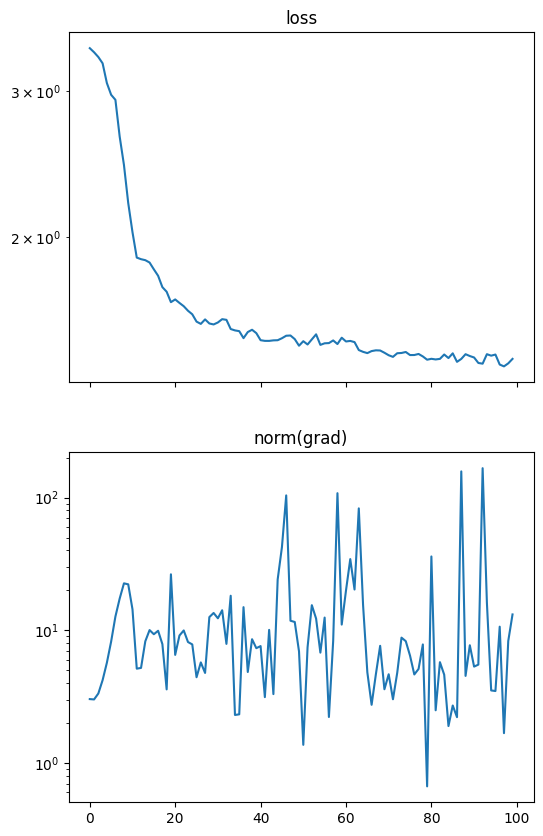

In [11]:
key = jax.random.key(71)

# all selected snapshots except the initial conditions
i_ref = jnp.arange(1, len(i_snapshots))

for i in (pbar := tqdm.tqdm(range(total_steps))):
    key, subkey = jax.random.split(key)
    train_step_wrapper(i0=0, i_ref=i_ref, aug_key=subkey)

plot_training(losses, grads)

### checkpointing

In [14]:
pressure_model.save(checkpoint_file)

Checkpoint saved to /global/u2/a/athomsen/flatiron/JaxHPM/notebooks/../data/checkpoints/pressure_parts=64,mesh=64.jx


# testing

Solving ODE in 85 steps (StepTo with 20 steps between ts)
dark matter and gas
dark matter and gas
dark matter and gas
Solving ODE in 85 steps (StepTo with 20 steps between ts)
dark matter and gas
Using learned pressure force
No latent variable
dark matter and gas
Using learned pressure force
No latent variable
dark matter and gas
Using learned pressure force
No latent variable


100%|██████████| 5/5 [00:15<00:00,  3.07s/it]


Solving ODE in 85 steps (StepTo with 20 steps between ts)
dark matter and gas
dark matter and gas
dark matter and gas
Solving ODE in 85 steps (StepTo with 20 steps between ts)
dark matter and gas
Using learned pressure force
No latent variable
dark matter and gas
Using learned pressure force
No latent variable
dark matter and gas
Using learned pressure force
No latent variable


100%|██████████| 5/5 [00:15<00:00,  3.04s/it]


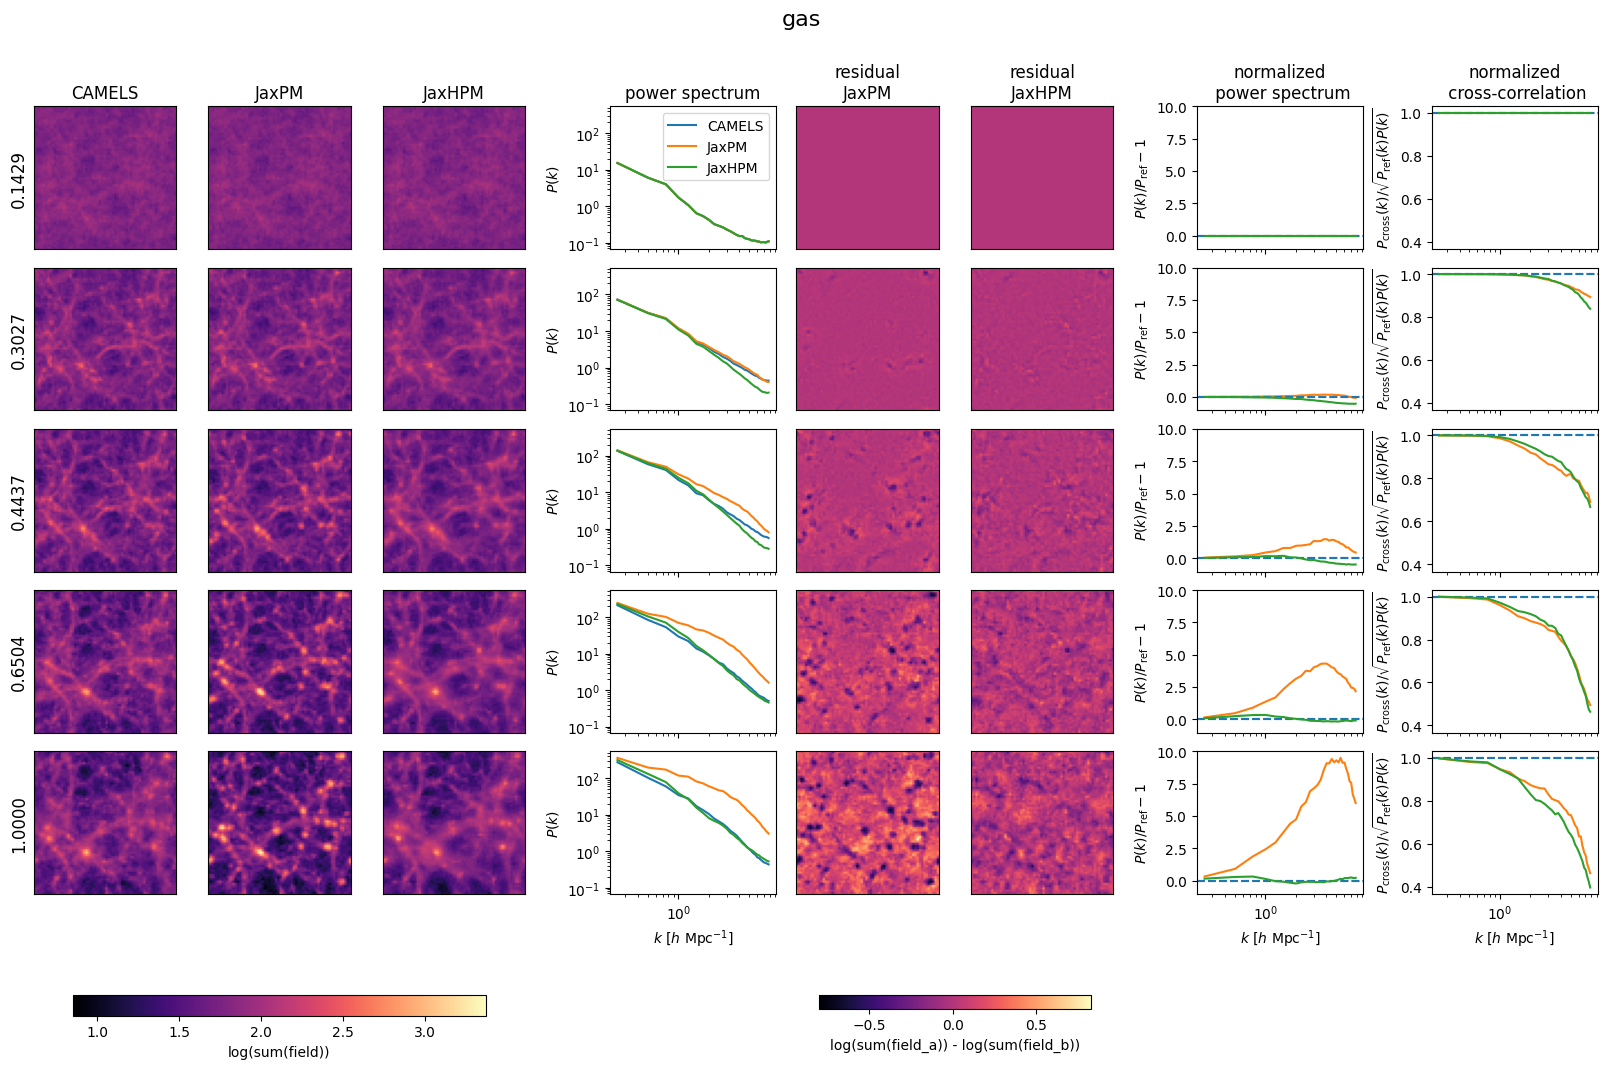

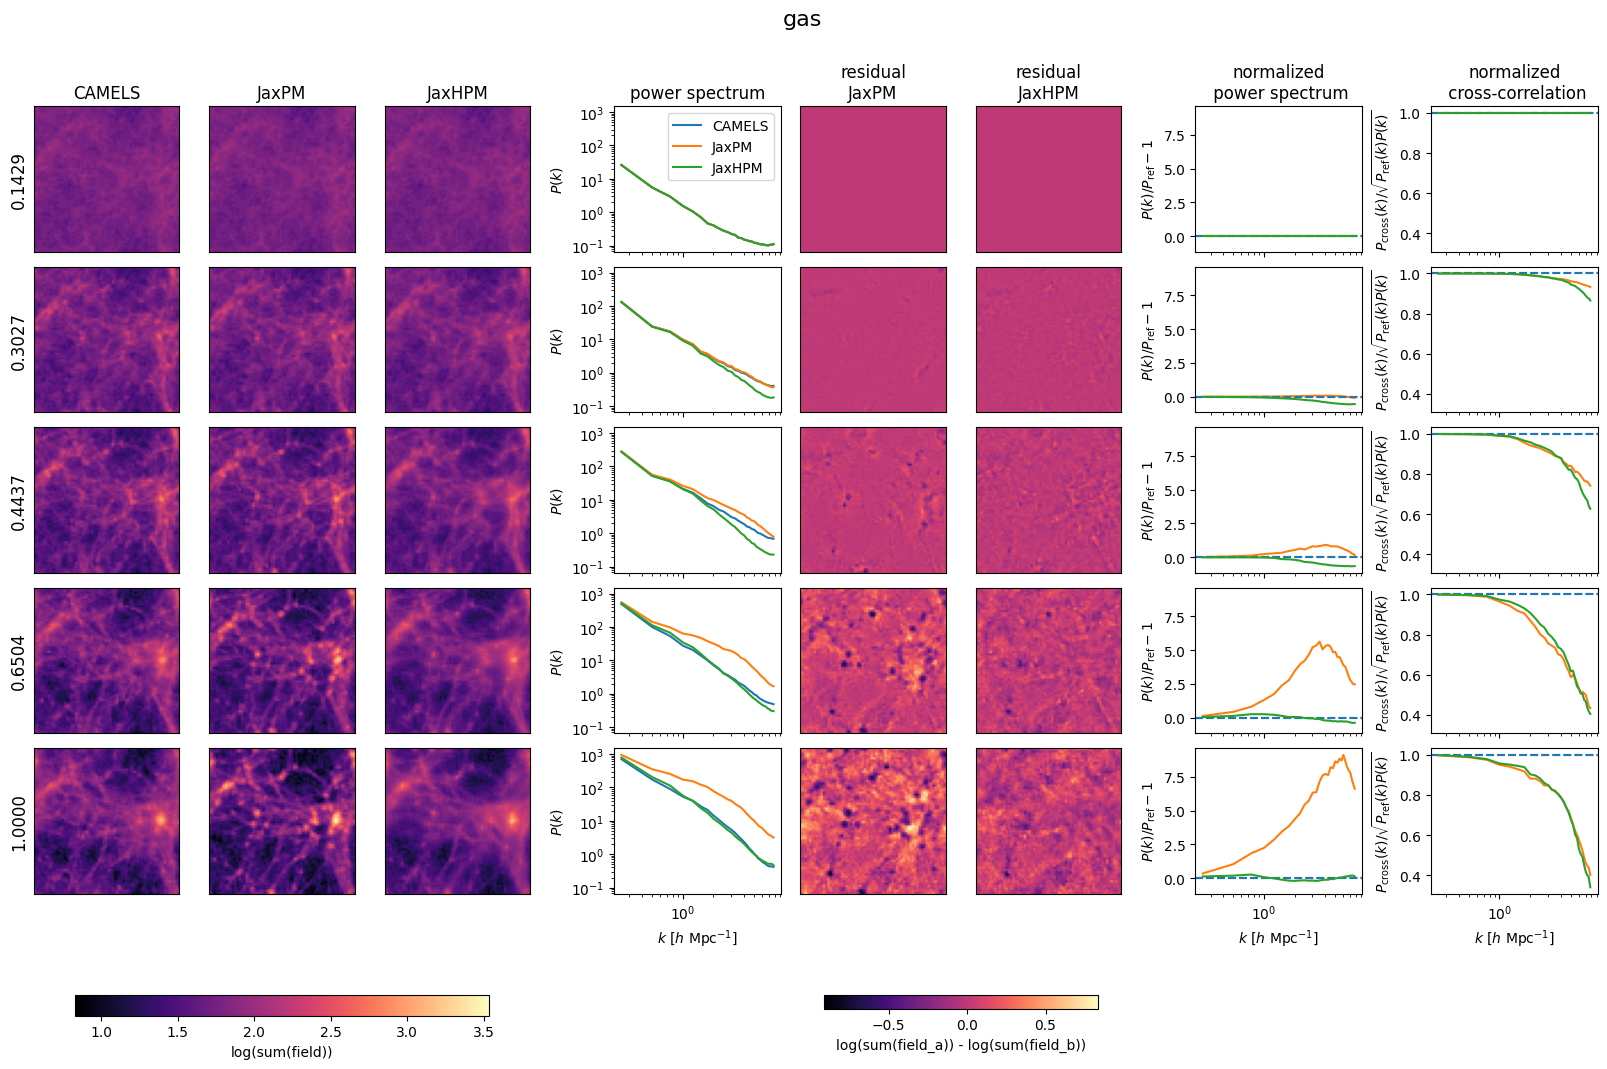

In [13]:
for camels_dict in [train_dict, vali_dict]:
    diagnostics.run_simulations(
        camels_dict,
        mesh_per_dim,
        pressure_model=pressure_model, 
        nt=20,
        plot_dm=False,
        plot_gas=True,
    )